In [1]:
from dataclasses import dataclass
import random
import numpy as np

from tqdm.notebook import tqdm
import torch
import plotting
import matplotlib.pyplot as plt

# Source definition

let's start from a super simple source given by a sinc function parametrized by the vector $\theta$
$$ \phi(\theta) = sinc\left( \frac{(t- \theta_1)}{\theta_0} \right) $$


a more realistic source would be:
$$\phi(\theta) = cos(\theta_0 t + \theta_1 t^3) $$

In [44]:
@dataclass
class Source:
    theta: np.ndarray
    lambd: float

    def signal(self, t: np.ndarray) -> np.ndarray:
        period, shift = self.theta[0], self.theta[1]
        return np.sinc((t-shift) / period) * self.lambd

    @classmethod
    def sample(cls, n_sources=1) -> list["Source"]:
        if n_sources == 1:
            lambd = random.uniform(0.5, 2)
            period = random.uniform(0.8, 1.2)
            shift = random.uniform(-2, 2)

            return [cls(theta=np.array([period, shift]), lambd=lambd)]
        if n_sources > 1:
            return [cls.sample()[0] for _ in range(n_sources)]
        else:
            raise ValueError("n_sources must be positive")

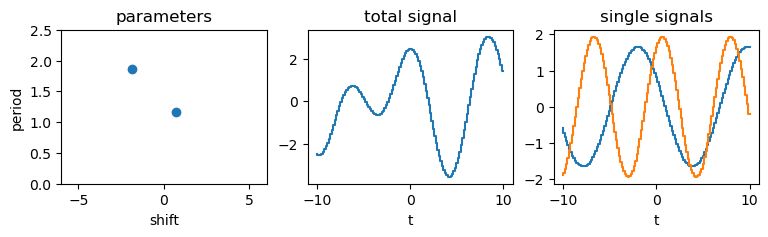

In [38]:
n_sources = 2
t = np.linspace(-10.0, 10.0, 256)
sources = Source.sample(n_sources=n_sources)
plotting.plot_multi(sources, t=t)

# Generate sources 

# Approximate with net

In [39]:
def conv_block(idx: int, hidden_size=32):
    return torch.nn.Sequential(
        torch.nn.LazyConv1d(hidden_size, 3, dilation=2**idx, padding="same"),  # type: ignore
        torch.nn.LazyBatchNorm1d(),
        torch.nn.ReLU(),
    )


def linear_block(idx: int, hidden_size=32):
    return torch.nn.Sequential(
        torch.nn.LazyLinear(out_features=hidden_size),
        torch.nn.LazyBatchNorm1d(),
        torch.nn.ReLU(),
    )


class SignalEncoder(torch.nn.Module):
    def __init__(self, max_sources: int, n_source_params: int):
        super().__init__()
        self.n_sources = max_sources
        self.n_source_params = n_source_params

        self.common = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            linear_block(0, hidden_size=256),
            linear_block(0, hidden_size=256),
        )
        out_dims = max_sources * (n_source_params + 1)
        self.head_mean = torch.nn.LazyLinear(out_features=out_dims)
        self.head_log_std = torch.nn.LazyLinear(out_features=out_dims)

    def forward(self, x: torch.Tensor):
        common = self.common(x)
        mu = self.head_mean(common)
        if not self.training:
            return mu.reshape(-1, self.n_sources, self.n_source_params + 1)
        else:
            log_sigma = self.head_log_std(common)
            sigma = torch.exp(log_sigma)
            z = mu + sigma * torch.normal(0, 1, size=sigma.shape).to(sigma.device)
            kl = sigma**2 + mu**2 - log_sigma - 0.5
            res = z.reshape(-1, self.n_sources, self.n_source_params + 1)
            kl = kl.reshape(-1, self.n_sources, self.n_source_params + 1)
            return res, kl


def unpack_params(params: torch.Tensor):
    # params shape: (n_batch, n_sources, n_source_params + 1)
    log_periods = params[:, :, 0]
    shifts = params[:, :, 1]
    log_lambdas = params[:, :, 2]
    return log_periods.exp(), shifts, log_lambdas.exp()


def decode(params: torch.Tensor, times: torch.Tensor):
    periods, shifts, lambdas = unpack_params(params)

    # needed to make broadcasting work (avoids loops)
    periods = periods.unsqueeze(0)  # shape: (1, n_batch, n_sources)
    shifts = shifts.unsqueeze(0)  # shape: (1, n_batch, n_sources)
    lambdas = lambdas.unsqueeze(0)  # shape: (1, n_batch, n_sources)
    times = times.unsqueeze(1).unsqueeze(1)  # shape: (n_times, 1, 1)

    # shape (n_times, n_batch, n_sources)
    signals = torch.sinc((times - shifts) / periods) * lambdas
    return signals.sum(dim=-1).T  # shape: (n_batch, n_times)


def get_sources_from(params: torch.Tensor) -> list[list[Source]]:
    periods, shifts, lambdas = unpack_params(params)

    periods = periods.detach().cpu().numpy()
    shifts = shifts.detach().cpu().numpy()
    lambdas = lambdas.detach().cpu().numpy()
    thetas = np.stack([periods, shifts], axis=-1)

    return [
        [
            Source(theta=theta, lambd=lambd)
            for theta, lambd in zip(thetas_batch, lambdas_batch)
        ]
        for thetas_batch, lambdas_batch in zip(thetas, lambdas)
    ]

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SignalEncoder(max_sources=n_sources, n_source_params=2).to(device)
print(encoder)

SignalEncoder(
  (common): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): LazyLinear(in_features=0, out_features=256, bias=True)
      (1): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): LazyLinear(in_features=0, out_features=256, bias=True)
      (1): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (head_mean): LazyLinear(in_features=0, out_features=6, bias=True)
  (head_log_std): LazyLinear(in_features=0, out_features=6, bias=True)
)


c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


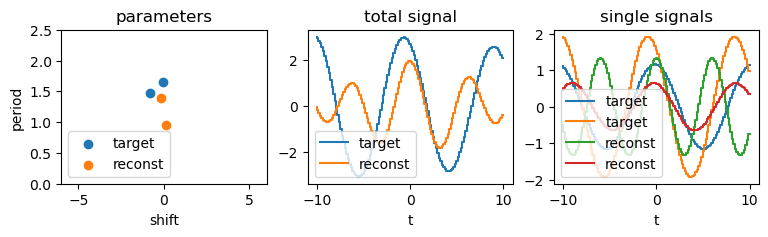

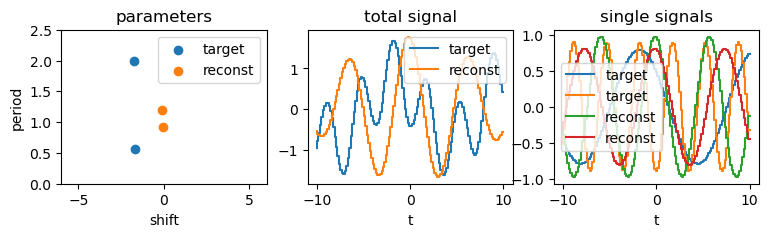

In [41]:
def create_batch(batch_size: int, n_sources: int, t: np.ndarray):
    sources = [Source.sample(n_sources) for _ in range(batch_size)]
    signals = [np.sum([source.signal(t) for source in ss], axis=0) for ss in sources]
    signals = torch.as_tensor(np.array(signals), dtype=torch.float32).unsqueeze(1)
    return signals, sources


encoder.eval()
signals, sources_target = create_batch(batch_size=2, n_sources=n_sources, t=t)
params = encoder(signals.to(device))
sources_reconstructed = get_sources_from(params)

for sources_t, sources_r in zip(sources_target, sources_reconstructed):
    plotting.plot_multi(sources_t, t=t, label="target")
    plotting.plot_multi(sources_r, t=t, label="reconst", new_fig=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: 11.123295747675002, kl: 0.001634491907680058
Epoch 1: 1.8951371796429157, kl: 0.0019392883832551888
Epoch 2: 1.7714310893788934, kl: 0.0019719059991984977
Epoch 3: 1.6705253683030605, kl: 0.0021796717828692636
Epoch 4: 1.6488848458975554, kl: 0.0023903165147203254
Epoch 5: 1.6373645765706897, kl: 0.0025587608561181696
Epoch 6: 1.6216063862666488, kl: 0.0026838853609660873
Epoch 7: 1.6300740567967296, kl: 0.002789979358567507
Epoch 8: 1.6029425114393234, kl: 0.0028865638541901717
Epoch 9: 1.5729606244713068, kl: 0.0029691254549106816
Epoch 10: 1.579490120522678, kl: 0.0030381094220501836
Epoch 11: 1.601703628897667, kl: 0.0031024432191770757
Epoch 12: 1.5990680316463113, kl: 0.003148993222566787
Epoch 13: 1.6139002852141857, kl: 0.00319333803417976
Epoch 14: 1.5941822119057178, kl: 0.003234277290175669
Epoch 15: 1.5879865754395723, kl: 0.0032582832900516223
Epoch 16: 1.5765291368588805, kl: 0.00329784903806285
Epoch 17: 1.554054792970419, kl: 0.003314767964184284
Epoch 18: 1.57

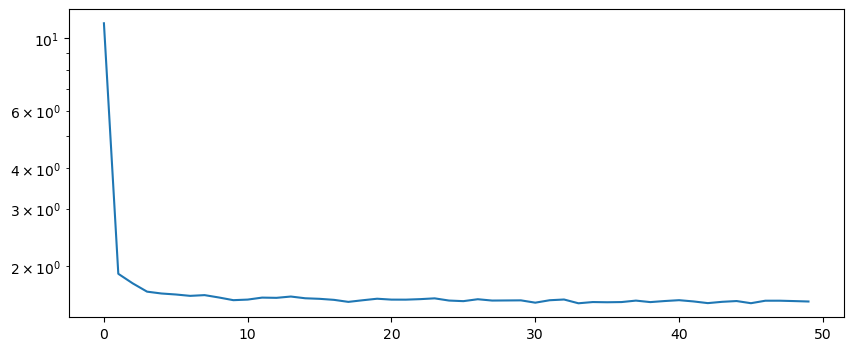

In [42]:
encoder.train()
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
times = torch.as_tensor(t, dtype=torch.float32, device=device)
beta = 1e-3

loss_log = []
for epoch in tqdm(range(50)):
    epoch_loss_log = []
    epoch_kl_log = []
    for batch in range(128):
        signals_targ, _ = create_batch(batch_size=32, n_sources=n_sources, t=t)
        signals_targ = signals_targ.to(device)
        
        params, kl = encoder(signals_targ)
        signals_rec = decode(params, times)
        kl = kl.mean()*beta
        loss = ((signals_targ - signals_rec)**2).mean() + kl
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss_log.append(loss.item())
        epoch_kl_log.append(kl.item())
    loss_log.append(np.mean(epoch_loss_log))
    print(f"Epoch {epoch}: {loss_log[-1]}, kl: {np.mean(epoch_kl_log)}")

plt.figure(figsize=(10, 4))
plt.semilogy(loss_log)
plt.show()

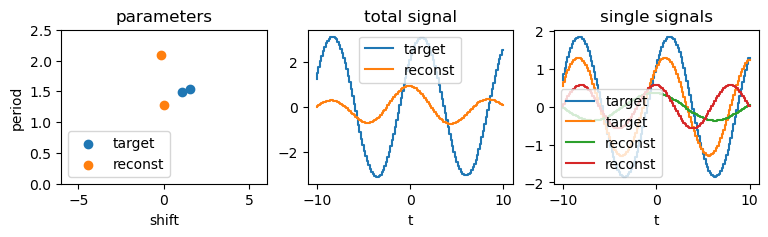

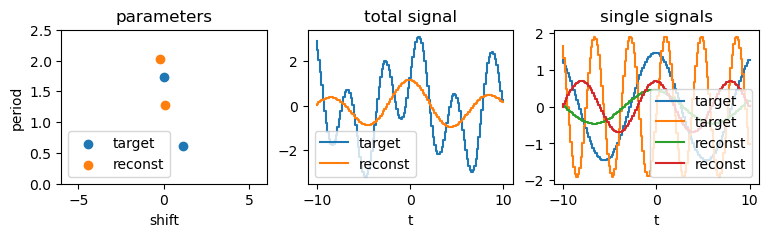

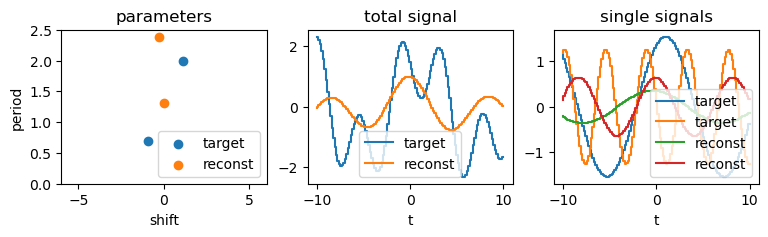

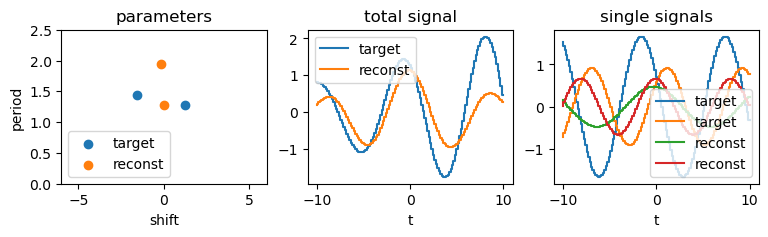

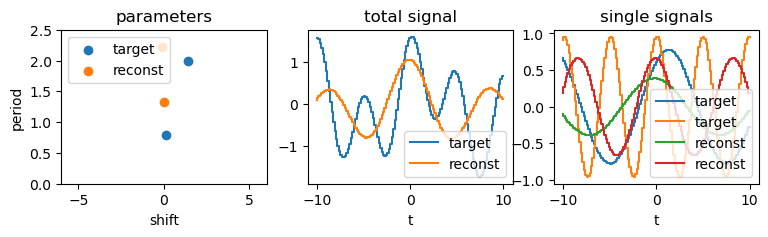

In [43]:
encoder.eval()
signals, sources_target = create_batch(batch_size=5, n_sources=n_sources, t=t)
params = encoder(signals.to(device))
sources_reconstructed = get_sources_from(params)

for sources_t, sources_r in zip(sources_target, sources_reconstructed):
    plotting.plot_multi(sources_t, t=t, label="target")
    plotting.plot_multi(sources_r, t=t, label="reconst", new_fig=False)

# Other

TODO: impose integral constraints on net output
    $$N(a,b) \approx \int_a^b c(\theta) d\theta$$

In [4]:
from typing import Optional


@dataclass
class SignalSampler:
    approx_integral: Callable[[Array1d, Array1d], float]
    integration_range: tuple[Array1d, Array1d]

    def sample_signal(self) -> Callable[[Array1d], Array1d]:
        sources = [
            Source.from_theta_lambda(
                theta=np.random.uniform(theta_min, theta_max),  # type: ignore
                lambd=self.approx_integral(theta_min, theta_max),
            )
            for theta_min, theta_max in self.decompose_integral(self.integration_range)
        ]

        return lambda t: np.sum([source.signal(t) for source in sources], axis=0)

    def decompose_integral(
        self,
        integration_range: Optional[tuple[Array1d, Array1d]] = None,
        budget: int = 100,
    ) -> list[tuple[Array1d, Array1d]]:
        if integration_range is None:
            integration_range = self.integration_range
        theta_min, theta_max = integration_range
        if budget <= 1 or np.linalg.norm(theta_max - theta_min) < 1e-4:
            return [(theta_min, theta_max)]

        pivot_dim = random.randint(0, len(theta_min) - 1)
        pivot = random.uniform(theta_min[pivot_dim], theta_max[pivot_dim])

        theta_max_left = theta_max.copy()
        theta_max_left[pivot_dim] = pivot

        theta_min_right = theta_min.copy()
        theta_min_right[pivot_dim] = pivot

        mass_left = self.approx_integral(theta_min, theta_max_left)
        mass_right = self.approx_integral(theta_min_right, theta_max)
        budget_left = int((budget - 1) * mass_left / (mass_left + mass_right + 1e-10))
        budget_right = int((budget - 1) * mass_right / (mass_left + mass_right + 1e-10))

        decomposition_left = self.decompose_integral(
            integration_range=(theta_min, theta_max_left), budget=budget_left
        )
        decomposition_right = self.decompose_integral(
            integration_range=(theta_min_right, theta_max), budget=budget_right
        )
        return decomposition_left + decomposition_right

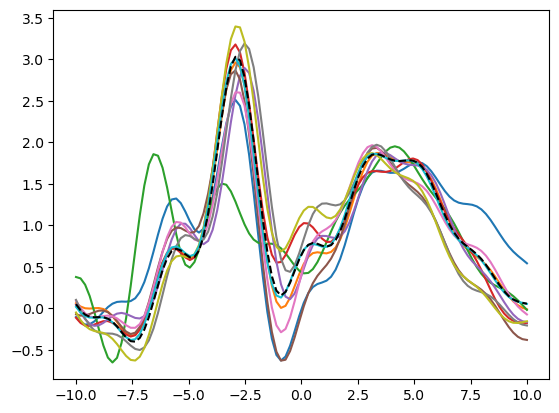

In [5]:
def true_d(thetamin: Array1d, thetamax: Array1d) -> float:
    # return sum of lambd for all souces in range
    return sum(
        source.lambd
        for source in true_souces
        if np.all(thetamin <= source.theta) and np.all(source.theta <= thetamax)
    )


sampler = SignalSampler(
    approx_integral=true_d,
    integration_range=tuple(np.array(theta) for theta in zip(omega_range, tau_range)),  # type: ignore
)

for _ in range(10):
    plt.plot(t, sampler.sample_signal()(t))
plt.plot(t, y, "--k", label="true signal")

LazyLinearNet(
  (0): LazyLinearCell(
    (0): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LazyLinear(in_features=0, out_features=32, bias=True)
    (2): ReLU()
  )
  (1): LazyLinearCell(
    (0): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LazyLinear(in_features=0, out_features=32, bias=True)
    (2): ReLU()
  )
  (2): LazyLinearCell(
    (0): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LazyLinear(in_features=0, out_features=1, bias=True)
  )
)


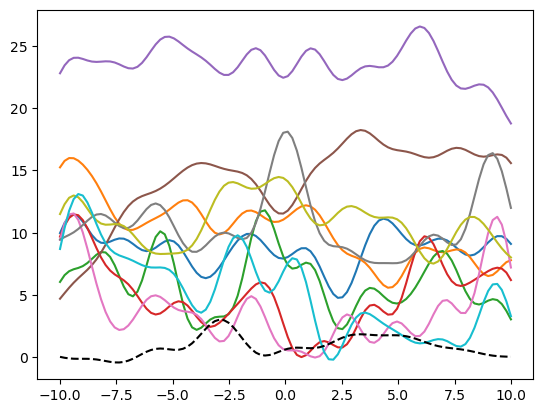

In [10]:
from networks import LazyLinearNet
import  torch


net = LazyLinearNet(out_features=1, hidden_features=(32,32))
print(net)

def nn_approaximate_d(thetamin: Array1d, thetamax: Array1d) -> float:
    net.eval()
    x = torch.tensor((thetamin, thetamax), dtype=torch.float32).flatten()
    return net(x.unsqueeze(0)).exp().item()

sampler = SignalSampler(
    approx_integral=nn_approaximate_d,
    integration_range=tuple(np.array(theta) for theta in zip(omega_range, tau_range)),  # type: ignore
)

for _ in range(10):
    plt.plot(t, sampler.sample_signal()(t))
plt.plot(t, y, "--k", label="true signal")

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
target = torch.tensor(y, dtype=torch.float32)

batch_size = 32
for epoch in range(50):
    for batch in range(10):
        integration_lims = np.array(sampler.decompose_integral(), dtype=np.float32)

        net.train()
        approx_lambdas = net(
            torch.as_tensor(integration_lims, dtype=torch.float32).flatten(start_dim=1)
        ).exp()
        
        optimizer.zero_grad()
        loss = torch.zeros(1)
        for _ in range(batch_size):
            thetas = [np.random.uniform(*lims) for lims in integration_lims]
            sources = [Source.from_theta_lambda(theta, 1.0) for theta in thetas]
            avg_signal = torch.tensor([source.signal(t) for source in sources], dtype=torch.float32)  # type: ignore
        
            approx_signal = torch.sum(approx_lambdas * avg_signal, dim=0)
            loss += torch.nn.MSELoss()(approx_signal, target)
            
            
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch} loss {loss.item():.2f}") # type: ignore

epoch 0 loss 7654.81
epoch 1 loss 1351.58
epoch 2 loss 17741.84
epoch 3 loss 28895.23
epoch 4 loss 3597.54
epoch 5 loss 6435.11
epoch 6 loss 10071.59
epoch 7 loss 6540.87
epoch 8 loss 4918.19
epoch 9 loss 4986.58
epoch 10 loss 5104.41
epoch 11 loss 10925.81
epoch 12 loss 5317.25
epoch 13 loss 24535.54
epoch 14 loss 5246.06
epoch 15 loss 39242.91
epoch 16 loss 8899.22
epoch 17 loss 12703.42
epoch 18 loss 4001.66
epoch 19 loss 2359.69
epoch 20 loss 1903.36
epoch 21 loss 3558.07
epoch 22 loss 5845.21
epoch 23 loss 9290.53
epoch 24 loss 6896.16
epoch 25 loss 8098.50
epoch 26 loss 8161.71
epoch 27 loss 5490.42
epoch 28 loss 18694.19
epoch 29 loss 22685.08
epoch 30 loss 4506.80
epoch 31 loss 2189.16
epoch 32 loss 2617.79
epoch 33 loss 7363.21
epoch 34 loss 4265.13
epoch 35 loss 4624.86
epoch 36 loss 4497.67
epoch 37 loss 4586.56
epoch 38 loss 5392.88
epoch 39 loss 9525.57
epoch 40 loss 4773.29
epoch 41 loss 7557.88
epoch 42 loss 13791.78
epoch 43 loss 5077.56
epoch 44 loss 8798.18
epoch 45 l

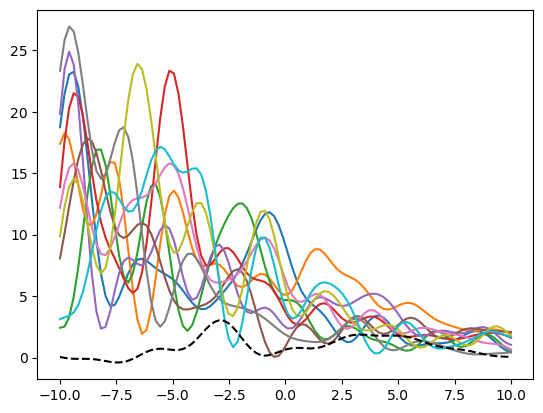

In [8]:
for _ in range(10):
    plt.plot(t, sampler.sample_signal()(t))
plt.plot(t, y, "--k", label="true signal")